## Import libraries

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from lenet5 import LeNet
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd

# from lenet5 import LeNet



## Set Parameters

In [2]:
# Check if cuda is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model Training Parameters
LEARNING_RATE = 2e-3  # LR
BATCH_SIZE = 32
ROUNDS = 1000  # R
LOCAL_EPOCHS = 1  # E
NUM_CLIENTS = 100  # K: number of total clients
C = 0.3 # percentage of clients selected at each round
# m = C * K : number of  clients selected at each round
NUM_SELECTED = max(int(C * NUM_CLIENTS), 1)

# Save plots in the folder ./plots or show them
SAVE_PLOTS = False

# Dirichlet's distribution
# NUM_CLIENTS must be = 100
DIRICHLET = True 
# Alpha value for the dirichlet's distribution
# Value possible for CIFAR10  : 0, 0.05, 0.1, 0.2, 0.5, 1, 10, 100
# Value possible for CIFAR100 : 0, 0.5, 1, 2, 5, 10, 100, 1000
ALPHA = 1

# If the clients have different numbers of images or not
DIFFERENT_SIZES = False 
DELTA = -1# controls how much the images numbers can vary from client to client

# Use batch normalization or not
BATCH_NORM = False 
# group normalization
GROUP_NORM = False 

# group normalization parameters
groupNormParams= {
'groupNL1' : 2,
'groupNL2' : 2
}


if GROUP_NORM ==True & BATCH_NORM ==True:
    print(" Cannot have group an batch normalization True at the same time")
    exit()

## Training and Validation functions

In [3]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for X, y_target in train_loader:

        # set gradient to zero
        optimizer.zero_grad()

        # If there is a GPU, pass the data to GPU
        X = X.to(device)
        y_target = y_target.to(device)

        # Prediction

        # Call model forward()
        y_predict, _ = model(X)

        # Get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)

        # Adjusting weights
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def test(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for X, y_target in valid_loader:

        # If there is a GPU, pass the data to the GPU
        X = X.to(device)
        y_target = y_target.to(device)

        # Prediction and loss

        # Call model forward()
        y_predict, _ = model(X)

        # Get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss


def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


def client_update(model, optimizer, train_loader, device, criterion, epochs):
    """
    This function updates/trains client model on client data
    """
    for e in range(epochs):
        model, optimizer, train_loss = train(train_loader, model,
                                             criterion, optimizer, device)
    return train_loss


def server_aggregate(global_model, client_models, client_idx, lengths):
    """
    This function has aggregation method 'mean'
    """
    # This will take simple mean of the weights of models

    totLength= float(sum(lengths))
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        globDict = 0
        for i in range(len(lengths)):
            globDict += client_models[client_idx[i]].state_dict()[k].float() * float(lengths[i]) / totLength
        global_dict[k] =globDict
            

    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict())


In [4]:
def training_loop(centralizedModel, federatedModels, criterion, optimizers, train_loader, test_loader,
                  rounds, epochs, num_clients, num_selected, device, print_every=1):

    avg_train_losses = []  # weighted average train losses between clients
    avg_train_accuracies = []  # weighted average train accuracies between clients

    valid_losses = []   
    valid_accuracies = []

    # Train model
    for round in range(rounds):

        # Select random clients
        # Select in the total number of clients, a random array of clients of size num_selected at each round
        client_idx = np.random.permutation(num_clients)[:num_selected]

        local_train_losses = []  # Local train losses of the clients in this round
        local_train_accuracies = []  # Local train accuracies of the clients in this round
        # Local validation accuracies of the clients in this round

        local_len = []
        tot_images = 0

        for i in range(num_selected):
            # Train federated model locally in client i for num_epochs epochs
            # FIX: local_train_loss = client_update(federatedModels[i], optimizers[i], train_loader[client_idx[i]], device, criterion, epochs)
            # FIX: local_train_acc = get_accuracy(federatedModels[i], train_loader[client_idx[i]], device)
            local_train_loss = client_update(federatedModels[client_idx[i]], optimizers[client_idx[i]], train_loader[client_idx[i]], device, criterion, epochs)
            local_train_acc = get_accuracy(federatedModels[client_idx[i]], train_loader[client_idx[i]], device)

            lenDataLoad = len(train_loader[client_idx[i]]) # number of images seen by that client
            tot_images += lenDataLoad
            local_len.append(lenDataLoad) # gets the number of images per data loader

            local_train_losses.append(local_train_loss * lenDataLoad) # Add the local loss for this client weighted with the number of images seen
            local_train_accuracies.append(local_train_acc * lenDataLoad)

        server_aggregate(centralizedModel, federatedModels, client_idx, local_len)

        # Calculate avg training loss over all selected users at each round
        avg_train_loss= sum(local_train_losses) / tot_images 
        avg_train_losses.append(avg_train_loss)

        # Calculate avg training accuracy over all selected users at each round
        avg_train_acc = sum(local_train_accuracies) / tot_images 
        avg_train_accuracies.append(avg_train_acc)

        # Validation

        # Disable gradient calculation to save memory
        with torch.no_grad():
            model, valid_loss = test(test_loader, centralizedModel, criterion, device)
            valid_losses.append(valid_loss)

            valid_acc = get_accuracy(centralizedModel, test_loader, device)
            valid_accuracies.append(valid_acc)



        print(f'Round: {round}\t'
              f'Average Train loss: {avg_train_loss:.4f}\t'
              f'Valid loss: {valid_loss:.4f}\t'
              f'Average Train accuracy: {100 * avg_train_acc:.2f}\t'
              f'Valid accuracy: {100 * valid_acc:.2f}')
    return centralizedModel, federatedModels, optimizers, (avg_train_losses, valid_losses), (avg_train_accuracies, valid_accuracies)


## Dirichlet's Distribution

In [5]:
def dirichlet(dataset, alpha):
    # CIFAR10
    train_file_name = "cifar10_v1.1/federated_train_alpha_"
    test_file_name = "cifar10_v1.1/test.csv"
    # CIFAR100
    # split_file_name = "cifar100_v1.1/federated_train_alpha_"
    #test_file_name = "cifar100_v1.1/test.csv"
    
    if 0 < alpha < 0.1:
        train_file_name += str(alpha) +".csv"
    elif 0 < alpha < 1:
        train_file_name += str(alpha) +"0.csv"
    else:
        train_file_name += str(alpha) + ".00.csv"
    train_file = pd.read_csv(train_file_name)
    test_file = pd.read_csv(test_file_name)
    print(test_file)

    client_img_index = [[] for _ in range(100)]
    for i,client_id in enumerate(train_file['user_id']):
        client_img_index[client_id].append(train_file['image_id'][i])

    traindata_split = [torch.utils.data.Subset(dataset, client_img_index[i]) for i in range(100)]
    return traindata_split

## Loaders and Transformations

In [6]:
# Image augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalizing the test images
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Loading CIFAR10 using torchvision.datasets
traindata = datasets.CIFAR10('./data', train=True, download=False,
                             transform=transform_train)


total_data = traindata.data.shape[0] # number of data

if DIRICHLET:
    print(f"Dirichlet with alpha: {ALPHA}")
    traindata_split = dirichlet(traindata, ALPHA)

elif DIFFERENT_SIZES:
    # Dividing the training data into num_clients, with each clients having different number of images
    min_val = max(int(total_data/ NUM_CLIENTS) - DELTA, 1) # min value of number of images for each client
    max_val = min(int(total_data/ NUM_CLIENTS) + DELTA, total_data - 1) # max value of number of images for each client

    indices = list(range(NUM_CLIENTS)) # list of indices for the splits of the data
    lengths = [random.randint(min_val,max_val) for i in indices] # List of lengths of splits to be produced

    diff = sum(lengths) - total_data # we are off by this abount 

    # Iterate through, incrementing/decrementing a random index 
    while diff != 0:  
        addthis = 1 if diff > 0 else -1 # +/- 1 depending on if we were above or below target.
        diff -= addthis

        idx = random.choice(indices) # Pick a random index to modify, check if it's OK to modify
        while not (min_val < (lengths[idx] - addthis) < max_val): 
            idx = random.choice(indices) # Not OK to modify.  Pick another.

        lengths[idx] -= addthis #Update that index.
    
    print("Number of Images for each client:")
    print(lengths)
    
    traindata_split = torch.utils.data.random_split(traindata, lengths)

else:
    delta = -1 # Not used, just to print it
    # Dividing the training data into num_clients, with each client having equal number of images
    traindata_split = torch.utils.data.random_split(traindata, [int(total_data/ NUM_CLIENTS) for _ in range(NUM_CLIENTS)])

# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(
    x, batch_size=BATCH_SIZE, shuffle=True) for x in traindata_split]


# Loading the test iamges and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./data', train=False,
                                                           transform=transforms.Compose([transforms.ToTensor(),
                                                                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
                                                           ), batch_size=BATCH_SIZE, shuffle=True)


Dirichlet with alpha: 1
      image_id  class
0            0      3
1            1      8
2            2      8
3            3      0
4            4      6
...        ...    ...
9995      9995      8
9996      9996      3
9997      9997      5
9998      9998      1
9999      9999      7

[10000 rows x 2 columns]


## Model Selection

In [7]:
model = LeNet(BATCH_NORM,GROUP_NORM,groupNormParams).to(DEVICE)
centralizedModel = model



# FIX: # list of models, model per device SELECTED ( same model for each device in our case)
# FIX: # federatedModels = [model for _ in range(NUM_SELECTED)]

# list of models, model per num_clients devices ( same model for each device in our case)
federatedModels = [model for _ in range(NUM_CLIENTS)]

for models in federatedModels:
    # we initialize every model with the central
    models.load_state_dict(centralizedModel.state_dict())


optimizers = [torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
              for model in federatedModels]
criterion = nn.CrossEntropyLoss()


## Train

In [8]:
centralizedModel, federatedModels, optimizers, (train_losses, valid_losses), (train_accuracies, valid_accuracies) = training_loop(
    centralizedModel, federatedModels, criterion, optimizers, train_loader, test_loader, ROUNDS, LOCAL_EPOCHS, NUM_CLIENTS, NUM_SELECTED, DEVICE)


Round: 0	Average Train loss: 2.1876	Valid loss: 2.4037	Average Train accuracy: 37.87	Valid accuracy: 10.00
Round: 1	Average Train loss: 2.1521	Valid loss: 2.3567	Average Train accuracy: 45.89	Valid accuracy: 12.48
Round: 2	Average Train loss: 1.9146	Valid loss: 3.1309	Average Train accuracy: 66.19	Valid accuracy: 14.56
Round: 3	Average Train loss: 1.7583	Valid loss: 2.4172	Average Train accuracy: 70.92	Valid accuracy: 12.54
Round: 4	Average Train loss: 1.7382	Valid loss: 2.5703	Average Train accuracy: 66.99	Valid accuracy: 15.69
Round: 5	Average Train loss: 1.5684	Valid loss: 3.4417	Average Train accuracy: 68.93	Valid accuracy: 10.55
Round: 6	Average Train loss: 1.5403	Valid loss: 2.4124	Average Train accuracy: 75.64	Valid accuracy: 14.13
Round: 7	Average Train loss: 1.5161	Valid loss: 2.1613	Average Train accuracy: 71.38	Valid accuracy: 21.35
Round: 8	Average Train loss: 1.3466	Valid loss: 3.0758	Average Train accuracy: 75.51	Valid accuracy: 15.29
Round: 9	Average Train loss: 1.4118	V

## Plot Accuracy and Loss

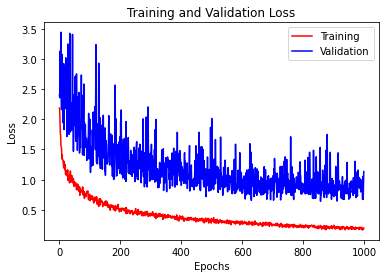

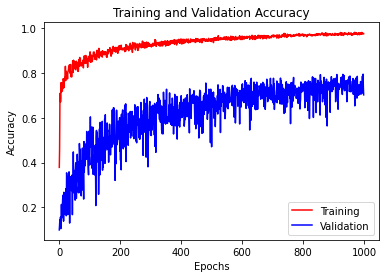

In [10]:
SAVE_PLOTS = False 
if SAVE_PLOTS:
    matplotlib.use("Agg")

# Plot Loss
plt.figure()
plt.title("Training and Validation Loss")
plt.plot(range(len(train_losses)), train_losses, color="r", label="Training")
plt.plot(range(len(valid_losses)), valid_losses, color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Loss")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    if DIRICHLET:
        plt.savefig("plots/federated_LR[{}]_R[{}]_K[{}]_C[{}]_E[{}]_A[{}]_BATCHNORM[{}]_GROUPNORM[{},{},{}]_loss.png".format(
            LEARNING_RATE, ROUNDS, NUM_CLIENTS, C, LOCAL_EPOCHS, ALPHA, BATCH_NORM, GROUP_NORM, groupNormParams['groupNL1'], groupNormParams['groupNL2']))
    else:
        plt.savefig("plots/federated_LR[{}]_R[{}]_K[{}]_C[{}]_E[{}]_D[{}]_BATCHNORM[{}]_GROUPNORM[{},{},{}]_loss.png".format(
            LEARNING_RATE, ROUNDS, NUM_CLIENTS, C, LOCAL_EPOCHS, delta, BATCH_NORM, GROUP_NORM, groupNormParams['groupNL1'], groupNormParams['groupNL2']))
else:
    plt.show()

# Plot Accuracy
plt.figure()
plt.title("Training and Validation Accuracy")
plt.plot(range(len(train_accuracies)),
         train_accuracies, color="r", label="Training")
plt.plot(range(len(valid_accuracies)), valid_accuracies,
         color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    if DIRICHLET:
        plt.savefig("plots/federated_LR[{}]_R[{}]_K[{}]_C[{}]_E[{}]_A[{}]_BATCHNORM[{}]_GROUPNORM[{},{},{}]_accuracy.png".format(
            LEARNING_RATE, ROUNDS, NUM_CLIENTS, C, LOCAL_EPOCHS, ALPHA, BATCH_NORM, GROUP_NORM, groupNormParams['groupNL1'], groupNormParams['groupNL2']))
    else:
        plt.savefig("plots/federated_LR[{}]_R[{}]_K[{}]_C[{}]_E[{}]_D[{}]_BATCHNORM[{}]_GROUPNORM[{},{},{}]_accuracy.png".format(
            LEARNING_RATE, ROUNDS, NUM_CLIENTS, C, LOCAL_EPOCHS, delta, BATCH_NORM, GROUP_NORM, groupNormParams['groupNL1'], groupNormParams['groupNL2']))
else:
    plt.show()


In [17]:
with open("FedAvgR{}E{}A{}.txt".format(ROUNDS,LOCAL_EPOCHS,ALPHA), "w") as f:
    for res in valid_accuracies:
        f.write(str(float(res)) + " \n")
        